In [32]:
import pandas as pd
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset , random_split
import matplotlib.pyplot as plt
from torchmetrics import Accuracy  
from tqdm import tqdm

In [3]:
train_path = 'https://raw.githubusercontent.com/FabioNicotra/fabionicotra.github.io/main/02_MobileClassification/train.csv'
test_path = 'https://raw.githubusercontent.com/FabioNicotra/fabionicotra.github.io/main/02_MobileClassification/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
train_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
x = train_df.drop('price_range', axis=1)
y = train_df['price_range']
y

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64

In [6]:
x.shape

(2000, 20)

In [7]:
x_train , x_valid , y_train , y_valid = train_test_split(x , y , train_size = 0.7 , random_state = 101)

In [8]:
x_train.shape

(1400, 20)

In [9]:
print(type(x_train))
print(type(x_train.values))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [10]:
x_train = torch.FloatTensor(x_train.values)
x_valid = torch.FloatTensor(x_valid.values)
y_train = torch.LongTensor(y_train.values)
y_valid = torch.LongTensor(y_valid.values)

In [11]:
mu = x_train.mean(axis = 0)
std = x_train.std(axis = 0)

In [12]:
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

In [13]:
train_data = TensorDataset (x_train , y_train)
valid_data = TensorDataset (x_valid , y_valid)

In [14]:
train_loader = DataLoader (train_data , 100 , True)
valid_loader = DataLoader (valid_data, 200 , False)

In [15]:
print(len(train_loader))
print(len(valid_loader))

14
3


In [16]:
x_batch , y_batch = next(iter(train_loader))
x_batch

tensor([[ 0.5083, -0.9841,  1.5854,  ...,  0.5683,  0.9925, -1.0097],
        [ 0.4270,  1.0155,  1.0907,  ...,  0.5683, -1.0068, -1.0097],
        [-1.2681, -0.9841, -1.2591,  ..., -1.7582, -1.0068,  0.9897],
        ...,
        [-1.6496,  1.0155, -1.0117,  ..., -1.7582, -1.0068, -1.0097],
        [-0.6790, -0.9841,  0.2250,  ...,  0.5683,  0.9925,  0.9897],
        [ 0.5467, -0.9841,  0.7197,  ...,  0.5683, -1.0068,  0.9897]])

In [17]:
num_feature = 20
num_class = 4
h1 = 64
h2 = 32
model = nn.Sequential(
    nn.Linear(num_feature , h1),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(h1 , h2),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(h2 , num_class)
)

In [18]:
model

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=4, bias=True)
)

In [22]:
loss_fn = nn.CrossEntropyLoss()
#weight_decay is l2_regularizer which compress the weights to make them smaller 
optimizer = optim.SGD( model.parameters() ,lr = 0.1 , momentum = 0.9 , nesterov = True , weight_decay = 1e-4)

📌 check forward path

In [23]:
#check out the model using a batch of data
yp = model (x_batch)
yp [:2,:]
print(loss_fn(yp , y_batch))

tensor(1.3949, grad_fn=<NllLossBackward0>)


In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

E:\workplace\python_install\Lib\site-packages\torch\cuda\__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [25]:
class AverageMeter(object):
    #computes and store the average and current value
    def __init__(self):
        self.reset()
    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0
    def update(self , val , n=1):
        self.val=val
        self.sum += val*n
        self.count +=n
        self.avg = self.sum /self.count

In [26]:
loss_meter = AverageMeter()

In [27]:
acc = Accuracy(task="multiclass", num_classes=4)

In [28]:
def train_one_epoch(model , train_loader ,loss_fn , optimizer , epoch = None):
    #some elements like dropout just runs in train process so we need to set train or eval flag
    model.train()
    loss_train =  AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=4).to(device)
    #acc_train = Accuracy(task="multiclass", num_classes=4)

    #to show train process in a progressbar we use tqdm 
    with tqdm(train_loader) as tepoch:
        for inputs,targets in tepoch:
            if epoch is not None:
                #to write the epoch number next to progressbar
                tepoch.set_description(f'Epoch {epoch}')
            inputs = inputs.to(device)
            targets = targets.to(device)
            yp = model(inputs)
            loss = loss_fn(yp , targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train.update(loss.item())
            #acc = torch.sum(yp.argmax(dim=1) == targets)
            acc_train(yp , targets)
            #to pass data that we want to show infront of the progressbar we use set_postfix
            tepoch.set_postfix(loss= loss_train.avg, accuracy = acc_train.compute().item()*100. )
    return model , loss_train.avg , acc_train.compute().item()
            

In [29]:
def evaluate (model , valid_loader , loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task="multiclass", num_classes=4).to(device)
        for i , (inputs,targets) in enumerate(valid_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            yp = model(inputs)
            loss = loss_fn(yp , targets)
            loss_valid.update(loss.item())
            acc_valid(yp , targets)
    return loss_valid.avg , acc_valid.compute()
            

📌 check backward path

In [33]:
#selecting 5 batch to check if model overfit? in this way check capasity of model 
#random_split(num_sample_required , num_rest_of_data)
mini_train_dataset , _ = random_split(train_data , (100, len(train_data)-100))
mini_loader = DataLoader(mini_train_dataset , 20, True)
for epoch in range (500):
    model , _ , _ = train_one_epoch(model , mini_loader , loss_fn , optimizer , epoch)

Epoch 499: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.94it/s, accuracy=31, loss=1.37]


📌 select best lr

In [37]:
for lr in [0.1,0.01,0.001,0.0001]:
    model = nn.Sequential(
    nn.Linear(num_feature , h1),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(h1 , h2),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(h2 , num_class)
    )
    optimizer = optim.SGD( model.parameters() ,lr = 0.1 , momentum = 0.9 ,
                          nesterov = True , weight_decay = 1e-4)
    print(f'lr = {lr}')
    for epoch in range (5):
        model , _ , _ = train_one_epoch(model , mini_loader , loss_fn , optimizer , epoch)
        
#loss drops bether in which lr 
#after selecting lr we make it specific and arange it with weigth_decay in a grid search 

lr = 0.1


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 94.15it/s, accuracy=75, loss=0.653]


lr = 0.01


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 96.28it/s, accuracy=72, loss=0.675]


lr = 0.001


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 102.68it/s, accuracy=64, loss=0.803]


lr = 0.0001


Epoch 4: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 94.56it/s, accuracy=73, loss=0.69]


📌 make small grid of lr and weight_decay = l2 regularization

In [39]:
for lr in [0.1 , 0.15 , 0.2 , 0.25 , 0.3]:
    for wd in [0. , 1e-4 , 1e-5 , 1e-6 ]:
        model = nn.Sequential(
        nn.Linear(num_feature , h1),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(h1 , h2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(h2 , num_class)
        )
        optimizer = optim.SGD( model.parameters() ,lr = lr , momentum = 0.9 ,
                              nesterov = True , weight_decay = wd)
        print(f'lr = {lr} , WD={wd}')
        for epoch in range (5):
            model , _ , _ = train_one_epoch(model , mini_loader , loss_fn , optimizer , epoch)
        

#again asses loss rate 
#you can show it in prettytable
# model.save.....

lr = 0.1 , WD=0.0


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 89.60it/s, accuracy=73, loss=0.647]


lr = 0.1 , WD=0.0001


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 92.43it/s, accuracy=62, loss=0.832]


lr = 0.1 , WD=1e-05


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 85.50it/s, accuracy=75, loss=0.676]


lr = 0.1 , WD=1e-06


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.09it/s, accuracy=82, loss=0.553]


lr = 0.15 , WD=0.0


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 65.18it/s, accuracy=79, loss=0.497]


lr = 0.15 , WD=0.0001


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 93.54it/s, accuracy=66, loss=0.807]


lr = 0.15 , WD=1e-05


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 100.34it/s, accuracy=81, loss=0.478]


lr = 0.15 , WD=1e-06


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 94.40it/s, accuracy=86, loss=0.413]


lr = 0.2 , WD=0.0


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 118.39it/s, accuracy=85, loss=0.363]


lr = 0.2 , WD=0.0001


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 116.08it/s, accuracy=77, loss=0.555]


lr = 0.2 , WD=1e-05


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 123.30it/s, accuracy=74, loss=0.801]


lr = 0.2 , WD=1e-06


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 113.44it/s, accuracy=77, loss=0.63]


lr = 0.25 , WD=0.0


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 127.39it/s, accuracy=76, loss=0.871]


lr = 0.25 , WD=0.0001


Epoch 4: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 124.10it/s, accuracy=66, loss=1.4]


lr = 0.25 , WD=1e-05


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 117.28it/s, accuracy=65, loss=1.19]


lr = 0.25 , WD=1e-06


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 110.10it/s, accuracy=76, loss=0.578]


lr = 0.3 , WD=0.0


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 111.29it/s, accuracy=81, loss=0.632]


lr = 0.3 , WD=0.0001


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 124.15it/s, accuracy=70, loss=0.968]


lr = 0.3 , WD=1e-05


Epoch 4: 100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 115.34it/s, accuracy=69, loss=0.897]


lr = 0.3 , WD=1e-06


Epoch 4: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 125.59it/s, accuracy=75, loss=1.01]


In [113]:
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []

#we set best valid to infinity
best_valid_loss = torch.inf
num_epoch=100
for epoch in range (num_epoch):
    model , loss_train , acc_train = train_one_epoch(model , train_loader , loss_fn , optimizer , epoch)
    loss_valid , acc_valid = evaluate(model , valid_loader , loss_fn)

    print(f'valid_loss: {float(loss_valid) : .4}, accuracy = {acc_valid } \n')
    
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)

    if loss_valid < best_valid_loss:
        torch.save(model , f'model{epoch}.pt')
        best_valid_loss = loss_valid 

print('done')

Epoch 0: 100%|███████████████████████████████████████████████| 14/14 [00:00<00:00, 94.52it/s, accuracy=31.1, loss=1.36]


valid_loss:  1.268, accuracy = 0.46666666865348816 



Epoch 1: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 120.46it/s, accuracy=56.4, loss=0.984]


valid_loss:  0.6041, accuracy = 0.8450000286102295 



Epoch 2: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 112.18it/s, accuracy=76.8, loss=0.545]


valid_loss:  0.3448, accuracy = 0.8566666841506958 



Epoch 3: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 118.53it/s, accuracy=81.5, loss=0.407]


valid_loss:  0.2505, accuracy = 0.9166666865348816 



Epoch 4: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 110.75it/s, accuracy=86.3, loss=0.326]


valid_loss:  0.244, accuracy = 0.9166666865348816 



Epoch 5: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 115.47it/s, accuracy=84.6, loss=0.349]


valid_loss:  0.3065, accuracy = 0.8600000143051147 



Epoch 6: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 113.99it/s, accuracy=88.3, loss=0.305]


valid_loss:  0.2172, accuracy = 0.9133333563804626 



Epoch 7: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 115.35it/s, accuracy=88.5, loss=0.298]


valid_loss:  0.2205, accuracy = 0.903333306312561 



Epoch 8: 100%|████████████████████████████████████████████████| 14/14 [00:00<00:00, 61.85it/s, accuracy=88, loss=0.289]


valid_loss:  0.2655, accuracy = 0.8816666603088379 



Epoch 9: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 110.01it/s, accuracy=88.7, loss=0.272]


valid_loss:  0.2282, accuracy = 0.8866666555404663 



Epoch 10: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 104.96it/s, accuracy=91, loss=0.238]


valid_loss:  0.2302, accuracy = 0.8983333110809326 



Epoch 11: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 115.50it/s, accuracy=88.5, loss=0.287]


valid_loss:  0.2841, accuracy = 0.8816666603088379 



Epoch 12: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 114.83it/s, accuracy=88.4, loss=0.293]


valid_loss:  0.2305, accuracy = 0.8899999856948853 



Epoch 13: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 118.96it/s, accuracy=89, loss=0.257]


valid_loss:  0.1849, accuracy = 0.9166666865348816 



Epoch 14: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 114.89it/s, accuracy=91.2, loss=0.216]


valid_loss:  0.2059, accuracy = 0.9150000214576721 



Epoch 15: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 128.19it/s, accuracy=93, loss=0.201]


valid_loss:  0.2607, accuracy = 0.8833333253860474 



Epoch 16: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 113.01it/s, accuracy=92.7, loss=0.186]


valid_loss:  0.2524, accuracy = 0.8966666460037231 



Epoch 17: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 113.86it/s, accuracy=92.7, loss=0.183]


valid_loss:  0.2406, accuracy = 0.8916666507720947 



Epoch 18: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 111.39it/s, accuracy=92.9, loss=0.195]


valid_loss:  0.1714, accuracy = 0.9283333420753479 



Epoch 19: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 108.39it/s, accuracy=92.5, loss=0.172]


valid_loss:  0.2261, accuracy = 0.8849999904632568 



Epoch 20: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 126.51it/s, accuracy=94.3, loss=0.152]


valid_loss:  0.1939, accuracy = 0.8999999761581421 



Epoch 21: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 119.43it/s, accuracy=93.7, loss=0.15]


valid_loss:  0.1885, accuracy = 0.9183333516120911 



Epoch 22: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 123.93it/s, accuracy=93.5, loss=0.167]


valid_loss:  0.173, accuracy = 0.9283333420753479 



Epoch 23: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 127.54it/s, accuracy=92.4, loss=0.193]


valid_loss:  0.2468, accuracy = 0.8849999904632568 



Epoch 24: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 113.89it/s, accuracy=92.6, loss=0.187]


valid_loss:  0.254, accuracy = 0.8949999809265137 



Epoch 25: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 116.44it/s, accuracy=93.7, loss=0.153]


valid_loss:  0.1891, accuracy = 0.9133333563804626 



Epoch 26: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 128.89it/s, accuracy=93.1, loss=0.17]


valid_loss:  0.1649, accuracy = 0.9333333373069763 



Epoch 27: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 117.69it/s, accuracy=94.1, loss=0.147]


valid_loss:  0.2117, accuracy = 0.9049999713897705 



Epoch 28: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 121.13it/s, accuracy=93.5, loss=0.168]


valid_loss:  0.2073, accuracy = 0.9049999713897705 



Epoch 29: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 125.91it/s, accuracy=93.9, loss=0.154]


valid_loss:  0.2071, accuracy = 0.9133333563804626 



Epoch 30: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 127.10it/s, accuracy=93.9, loss=0.144]


valid_loss:  0.2117, accuracy = 0.9116666913032532 



Epoch 31: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 126.89it/s, accuracy=94.6, loss=0.139]


valid_loss:  0.1936, accuracy = 0.9166666865348816 



Epoch 32: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 132.11it/s, accuracy=94.4, loss=0.143]


valid_loss:  0.2333, accuracy = 0.9016666412353516 



Epoch 33: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 128.73it/s, accuracy=93.5, loss=0.163]


valid_loss:  0.2496, accuracy = 0.8983333110809326 



Epoch 34: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 126.43it/s, accuracy=94.7, loss=0.144]


valid_loss:  0.1888, accuracy = 0.9316666722297668 



Epoch 35: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 121.39it/s, accuracy=94.4, loss=0.147]


valid_loss:  0.2043, accuracy = 0.92166668176651 



Epoch 36: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 123.01it/s, accuracy=95, loss=0.129]


valid_loss:  0.1997, accuracy = 0.92166668176651 



Epoch 37: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 111.00it/s, accuracy=94.9, loss=0.137]


valid_loss:  0.2186, accuracy = 0.9150000214576721 



Epoch 38: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 127.22it/s, accuracy=94.7, loss=0.127]


valid_loss:  0.255, accuracy = 0.8983333110809326 



Epoch 39: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 135.76it/s, accuracy=94.9, loss=0.14]


valid_loss:  0.2187, accuracy = 0.9183333516120911 



Epoch 40: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 127.72it/s, accuracy=95.1, loss=0.131]


valid_loss:  0.1809, accuracy = 0.925000011920929 



Epoch 41: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 123.69it/s, accuracy=95.1, loss=0.123]


valid_loss:  0.2187, accuracy = 0.9116666913032532 



Epoch 42: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 125.68it/s, accuracy=95.3, loss=0.127]


valid_loss:  0.2152, accuracy = 0.9066666960716248 



Epoch 43: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 133.42it/s, accuracy=95.1, loss=0.123]


valid_loss:  0.1758, accuracy = 0.92166668176651 



Epoch 44: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 118.78it/s, accuracy=95.9, loss=0.111]


valid_loss:  0.2146, accuracy = 0.9066666960716248 



Epoch 45: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 117.06it/s, accuracy=95.9, loss=0.109]


valid_loss:  0.2253, accuracy = 0.9083333611488342 



Epoch 46: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 126.35it/s, accuracy=95.1, loss=0.112]


valid_loss:  0.2071, accuracy = 0.92166668176651 



Epoch 47: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 138.80it/s, accuracy=96.4, loss=0.102]


valid_loss:  0.2324, accuracy = 0.9183333516120911 



Epoch 48: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 123.33it/s, accuracy=95.5, loss=0.122]


valid_loss:  0.2373, accuracy = 0.9133333563804626 



Epoch 49: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 128.34it/s, accuracy=94.7, loss=0.13]


valid_loss:  0.2431, accuracy = 0.8916666507720947 



Epoch 50: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 141.09it/s, accuracy=95.5, loss=0.117]


valid_loss:  0.2057, accuracy = 0.9183333516120911 



Epoch 51: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 121.93it/s, accuracy=95.8, loss=0.106]


valid_loss:  0.1901, accuracy = 0.9166666865348816 



Epoch 52: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 132.52it/s, accuracy=95.9, loss=0.117]


valid_loss:  0.2488, accuracy = 0.9049999713897705 



Epoch 53: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 118.34it/s, accuracy=96.6, loss=0.0919]


valid_loss:  0.2542, accuracy = 0.9150000214576721 



Epoch 54: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 119.84it/s, accuracy=96.9, loss=0.113]


valid_loss:  0.2357, accuracy = 0.9100000262260437 



Epoch 55: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 125.98it/s, accuracy=95.4, loss=0.118]


valid_loss:  0.2406, accuracy = 0.9133333563804626 



Epoch 56: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 132.09it/s, accuracy=96.1, loss=0.109]


valid_loss:  0.2839, accuracy = 0.8883333206176758 



Epoch 57: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 128.35it/s, accuracy=95.6, loss=0.125]


valid_loss:  0.2696, accuracy = 0.903333306312561 



Epoch 58: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 139.89it/s, accuracy=96.4, loss=0.088]


valid_loss:  0.2508, accuracy = 0.9150000214576721 



Epoch 59: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 122.17it/s, accuracy=96.1, loss=0.103]


valid_loss:  0.2781, accuracy = 0.9116666913032532 



Epoch 60: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 129.13it/s, accuracy=95.1, loss=0.132]


valid_loss:  0.2765, accuracy = 0.8983333110809326 



Epoch 61: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 133.80it/s, accuracy=96.1, loss=0.1]


valid_loss:  0.2568, accuracy = 0.903333306312561 



Epoch 62: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 127.68it/s, accuracy=96.1, loss=0.099]


valid_loss:  0.2923, accuracy = 0.9016666412353516 



Epoch 63: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 127.45it/s, accuracy=96.8, loss=0.114]


valid_loss:  0.2613, accuracy = 0.9066666960716248 



Epoch 64: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 133.43it/s, accuracy=96.4, loss=0.0859]


valid_loss:  0.2533, accuracy = 0.9166666865348816 



Epoch 65: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 110.26it/s, accuracy=96.8, loss=0.087]


valid_loss:  0.2376, accuracy = 0.9183333516120911 



Epoch 66: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 135.61it/s, accuracy=96, loss=0.111]


valid_loss:  0.233, accuracy = 0.9150000214576721 



Epoch 67: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 123.31it/s, accuracy=96.6, loss=0.084]


valid_loss:  0.2013, accuracy = 0.9166666865348816 



Epoch 68: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 125.92it/s, accuracy=95.6, loss=0.109]


valid_loss:  0.2231, accuracy = 0.9150000214576721 



Epoch 69: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 129.73it/s, accuracy=97.1, loss=0.0877]


valid_loss:  0.2066, accuracy = 0.9150000214576721 



Epoch 70: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 119.84it/s, accuracy=96.5, loss=0.0873]


valid_loss:  0.2262, accuracy = 0.9166666865348816 



Epoch 71: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 126.97it/s, accuracy=96.4, loss=0.101]


valid_loss:  0.2649, accuracy = 0.903333306312561 



Epoch 72: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 128.80it/s, accuracy=96.9, loss=0.0887]


valid_loss:  0.2624, accuracy = 0.9083333611488342 



Epoch 73: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 133.99it/s, accuracy=96.6, loss=0.0906]


valid_loss:  0.2602, accuracy = 0.9100000262260437 



Epoch 74: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 129.16it/s, accuracy=96.7, loss=0.0983]


valid_loss:  0.2888, accuracy = 0.9066666960716248 



Epoch 75: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 129.23it/s, accuracy=96.3, loss=0.102]


valid_loss:  0.2573, accuracy = 0.9116666913032532 



Epoch 76: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 126.11it/s, accuracy=96.1, loss=0.102]


valid_loss:  0.2473, accuracy = 0.9116666913032532 



Epoch 77: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 135.16it/s, accuracy=96.5, loss=0.076]


valid_loss:  0.2093, accuracy = 0.9200000166893005 



Epoch 78: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 123.70it/s, accuracy=96, loss=0.103]


valid_loss:  0.234, accuracy = 0.925000011920929 



Epoch 79: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 135.61it/s, accuracy=97.1, loss=0.0984]


valid_loss:  0.2307, accuracy = 0.9166666865348816 



Epoch 80: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 127.00it/s, accuracy=95.9, loss=0.111]


valid_loss:  0.2403, accuracy = 0.903333306312561 



Epoch 81: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 127.31it/s, accuracy=96.5, loss=0.0901]


valid_loss:  0.2004, accuracy = 0.9233333468437195 



Epoch 82: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 130.94it/s, accuracy=96.8, loss=0.0841]


valid_loss:  0.2402, accuracy = 0.9016666412353516 



Epoch 83: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 134.36it/s, accuracy=96.9, loss=0.0823]


valid_loss:  0.2133, accuracy = 0.92166668176651 



Epoch 84: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 132.70it/s, accuracy=96.6, loss=0.0923]


valid_loss:  0.18, accuracy = 0.9283333420753479 



Epoch 85: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 127.64it/s, accuracy=96.6, loss=0.0857]


valid_loss:  0.2057, accuracy = 0.9150000214576721 



Epoch 86: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 147.64it/s, accuracy=96.6, loss=0.0895]


valid_loss:  0.2247, accuracy = 0.9283333420753479 



Epoch 87: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 134.57it/s, accuracy=96.4, loss=0.0962]


valid_loss:  0.236, accuracy = 0.92166668176651 



Epoch 88: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 133.84it/s, accuracy=96.4, loss=0.0893]


valid_loss:  0.2014, accuracy = 0.9183333516120911 



Epoch 89: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 133.28it/s, accuracy=95.7, loss=0.122]


valid_loss:  0.2408, accuracy = 0.903333306312561 



Epoch 90: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 134.16it/s, accuracy=97.1, loss=0.084]


valid_loss:  0.2231, accuracy = 0.92166668176651 



Epoch 91: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 136.29it/s, accuracy=97, loss=0.0811]


valid_loss:  0.219, accuracy = 0.9233333468437195 



Epoch 92: 100%|████████████████████████████████████████████| 14/14 [00:00<00:00, 134.08it/s, accuracy=97.3, loss=0.078]


valid_loss:  0.2234, accuracy = 0.9133333563804626 



Epoch 93: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 134.00it/s, accuracy=97, loss=0.0792]


valid_loss:  0.3007, accuracy = 0.903333306312561 



Epoch 94: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 135.61it/s, accuracy=97, loss=0.0804]


valid_loss:  0.2595, accuracy = 0.9083333611488342 



Epoch 95: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 140.74it/s, accuracy=96.5, loss=0.0926]


valid_loss:  0.2911, accuracy = 0.9116666913032532 



Epoch 96: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 140.16it/s, accuracy=96.9, loss=0.08]


valid_loss:  0.2597, accuracy = 0.9116666913032532 



Epoch 97: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 131.39it/s, accuracy=97, loss=0.0833]


valid_loss:  0.238, accuracy = 0.9233333468437195 



Epoch 98: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 125.64it/s, accuracy=97, loss=0.0873]


valid_loss:  0.2792, accuracy = 0.9183333516120911 



Epoch 99: 100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 128.93it/s, accuracy=96.9, loss=0.0875]

valid_loss:  0.2905, accuracy = 0.9116666913032532 

done


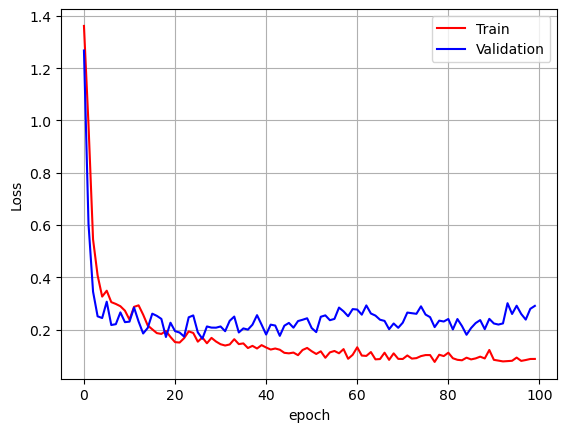

In [114]:
plt.plot(range(num_epoch), loss_train_hist , 'r-', label= 'Train')
plt.plot(range(num_epoch), loss_valid_hist , 'b-', label= 'Validation')

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

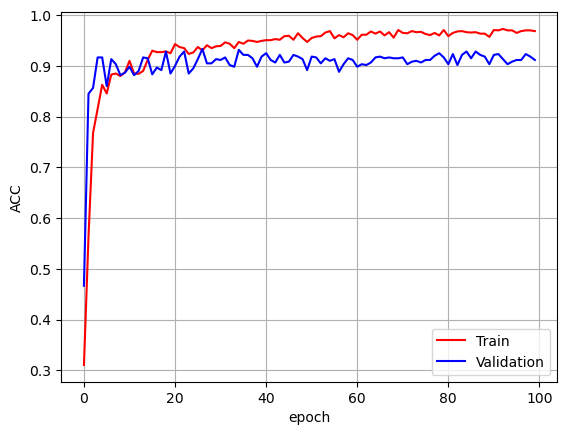

In [115]:
plt.plot(range(num_epoch), acc_train_hist , 'r-', label= 'Train')
plt.plot(range(num_epoch), acc_valid_hist , 'b-', label= 'Validation')

plt.xlabel('epoch')
plt.ylabel('ACC')
plt.grid(True)
plt.legend()